
# <b>Tutorial 4: Advanced data analysis</b>



## Learning Objectives:

In this session we will learn: 
1. to calculate frequency of wet days
2. to calculate percentiles
3. how to calculate some useful climate extremes statistics

## Contents

1. [Frequency of wet days](#freq)
2. [Percentiles](#percent)
3. [Investigating extremes](#extremes)
4. [Exercises](#exercise)

<div class="alert alert-block alert-warning">
<b>Prerequisites</b> <br> 
- Basic programming skills in python<br>
- Familiarity with python libraries Iris, Numpy and Matplotlib<br>
- Basic understanding of climate data<br>
- Tutorial 1, 2 and 3
</div>

___

## 1. Frequency of wet days<a id='freq'></a>
### 1.1 Import libraries
Import the necessary libraries. Current datasets are in zarr format, we need zarr and xarray libraries to access the data

In [1]:
import numpy as np
import xarray as xr
import zarr
import iris
import os
from cssp_utils import zarr_reader
from iris.analysis import Aggregator
import dask
dask.config.set(scheduler=dask.get)
import dask.array as da
import iris.quickplot as qplt
import iris.plot as iplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from catnip.preparation import extract_rot_cube, add_bounds
from xarray_iris_coord_system import XarrayIrisCoordSystem as xics
xi = xics()
xr.set_options(display_style='text') # Work around for AML bug that won't display HTML output.

<div class="alert alert-block alert-warning">
<b>Prerequisites</b> <br> 
- Basic programming skills in python<br>
- Familiarity with python libraries Iris, Numpy and Matplotlib<br>
- Basic understanding of climate data<br>
- Tutorials 1, 2 and 3
</div>

___

### 1.2 Set up authentication for the Azure blob store

The data for this course is held online in an Azure Blob Storage Service. To access this we use a SAS (shared access signature).  You should have been given the credentials for this service before the course, but if not please ask your instructor. We use the getpass module here to avoid putting the token into the public domain. Run the cell below and in the box enter your SAS and press return. This will store the password in the variable SAS.

In [2]:
import getpass
# SAS WITHOUT leading '?'
SAS = getpass.getpass()

 ····················································································


We now use the Zarr library to connect to this storage. This is a little like opening a file on a local file system but works without downloading the data. This makes use of the Azure Blob Storage service. The zarr.ABStore method returns a zarr.storage.ABSStore object which we can now use to access the Zarr data in the same way we would use a local file. If you have a Zarr file on a local file system you could skip this step and instead just use the path to the Zarr data below when opening the dataset.

In [ ]:
store = zarr.ABSStore(container='metoffice-20cr-ds', prefix='daily/', account_name="metdatasa", blob_service_kwargs={"sas_token":SAS})
type(store)

### 1.3 Read daily data
A Dataset consists of coordinates and data variables. Let's use the xarray's **open_zarr()** method to read all our zarr data into a dataset object and display it's metadata

In [ ]:
# use the open_zarr() method to read in the whole dataset metadata
dataset = xr.open_zarr(store)
# print out the metadata
dataset

Convert the dataset into an iris cubelist.

In [ ]:
from xarray_iris_coord_system import XarrayIrisCoordSystem as xics
xi = xics()
# create an empty list to hold the iris cubes
cubelist = iris.cube.CubeList([])

# use the DataSet.apply() to convert the dataset to Iris Cublelist
dataset.apply(lambda da: cubelist.append(xi.to_iris(da)))

# print out the cubelist.
cubelist

---

<div class="alert alert-block alert-info">
    <b>Note:</b> The following <b>sections</b> demonstrate analysis of moderate extremes. The basis of climate extremes analysis is a common set of standard extreme climate indices, defined by the World Climate Research Programme <a href="https://www.wcrp-climate.org/etccdi">Expert Team on Climate Change Detection and Indices (ETCCDI)</a>
    
<br>There are 27 climate extremes indices, nicely summarised by the <a href="https://www.climdex.org/learn/indices/">Climdex</a> website.
</div>

### 1.4 Calculate number of wet days ($\mathrm{pr} \geq 1 mm \;day^{-1}$)

In this section we'll be looking at wet days, a threshold measure giving the count of days when $\mathrm{pr} \geq 1 mm \;day^{-1}$, and R95p, the 95th percentile of precipitation on wet days ($\mathrm{pr} \geq 1 mm \;day^{-1}$) in the 1851-1900 period over the Shanghai region.

In [ ]:
# Extract the 'precipitation_flux' cube
pflx = cubelist.extract_strict('precipitation_flux')
# To avoid warnings when collapsing coordinates and also when plotting, add bounds to all coordinates
pflx = add_bounds(pflx,['time', 'grid_latitude', 'grid_longitude'])

Applying the time and region constraint

In [8]:
# define time constraint and extract 1851-1900 period
start_time = 1851
end_time = 1900

# define the time constraint
time_constraint = iris.Constraint(time=lambda cell: start_time <= cell.point.year <= end_time)

# laod the data into cubes applying the time constraint
pflx = pflx.extract(time_constraint)

# extract Shangai region and constain with time

# defining Shangai region coords
min_lat=29.0
max_lat=32.0
min_lon=118.0
max_lon=123.0

# extract data for the the Shanghai region using extract_rot_cube() function
pflx = extract_rot_cube(pflx, min_lat, min_lon, max_lat, max_lon)

For each day: is rainfall >= 1? True/False

Sum over all days to get number of wet days at each grid point and then calcuate the percentage of wet days.


In [9]:
# Define a new aggregator to help count non-zero days
# (This uses a dask array to reduce memory load)
count_nonzero = Aggregator('count', None,
                           units_func=lambda units: 1,
                           lazy_func=da.count_nonzero)

wetdays = pflx.collapsed('time', count_nonzero)
wetdays.rename('number of wet days (>=1mm/day)')

In [10]:
# Find wet days as a percentage of total days
total_days = len(pflx.coord('time').points)
pcent_wetdays = (wetdays / total_days) * 100

# renaming the cube name and units
pcent_wetdays.rename('percentage of wet days (>=1mm/day)')
pcent_wetdays.units = '%'

Now, we can plot the number and percentage of wet days

In [ ]:
fig = plt.figure(figsize=(12, 6))
fig.suptitle('Number of wet days (1851-1900)', fontsize=16)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
qplt.pcolormesh(wetdays)
ax1.coastlines()
ax1 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
qplt.pcolormesh(pcent_wetdays)
ax1.coastlines()
plt.show()

<div class="alert alert-block alert-success">
    <b>Task:</b><br><ul>
        <li> Calculate and visualise the percentage difference of wet days from past (1851-1880) to recent (1981-2010) 30 years period.
    </ul>
</div>

In [12]:
# Extract the 'precipitation_flux' cube
pflx = cubelist.extract_strict('precipitation_flux')
# To avoid warnings when collapsing coordinates and also when plotting, add bounds to all coordinates
pflx = add_bounds(pflx,['time', 'grid_latitude', 'grid_longitude'])

time bounds added
grid_latitude bounds added
grid_longitude bounds added


In [13]:
# define historical time constraint and extract 1851-1880 period
start_time = 1851
end_time = 1880

# define the historical time constraint
past_time_constraint = iris.Constraint(time=lambda cell: start_time <= cell.point.year <= end_time)

# laod the data into cubes applying the time constraint
past_pflx = pflx.extract(past_time_constraint)

# define recent time constraint and extract 1981-2010 period
start_time = 1981
end_time = 2010

# define the recent time constraint
recent_time_constraint = iris.Constraint(time=lambda cell: start_time <= cell.point.year <= end_time)

# laod the data into cubes applying the time constraint
recent_pflx = pflx.extract(recent_time_constraint)

# defining Shangai region coords
min_lat=29.0
max_lat=32.0
min_lon=118.0
max_lon=123.0

# extract data for the the Shanghai region using extract_rot_cube() function
past_pflx = extract_rot_cube(past_pflx, min_lat, min_lon, max_lat, max_lon)
recent_pflx = extract_rot_cube(recent_pflx, min_lat, min_lon, max_lat, max_lon)

In [14]:
# Define a new aggregator to help count non-zero days
# (This uses a dask array to reduce memory load)
count_nonzero = Aggregator('count', None,
                           units_func=lambda units: 1,
                           lazy_func=da.count_nonzero)

# calculate for the past data
past_wetdays = past_pflx.collapsed('time', count_nonzero)
past_wetdays.rename('historical number of wet days (>=1mm/day)')

# Find wet days as a percentage of total days
total_days = len(past_wetdays.coord('time').points)
pcent_past_wetdays = (past_wetdays / total_days) * 100

# renaming the cube name and units
pcent_past_wetdays.rename('historical percentage of wet days (>=1mm/day)')
pcent_past_wetdays.units = '%'

# calculate for the recent data
recent_wetdays = recent_pflx.collapsed('time', count_nonzero)
recent_wetdays.rename('recent number of wet days (>=1mm/day)')

# Find wet days as a percentage of total days
total_days = len(recent_wetdays.coord('time').points)
pcent_recent_wetdays = (recent_wetdays / total_days) * 100

# renaming the cube name and units
pcent_recent_wetdays.rename('recent percentage of wet days (>=1mm/day)')
pcent_recent_wetdays.units = '%'


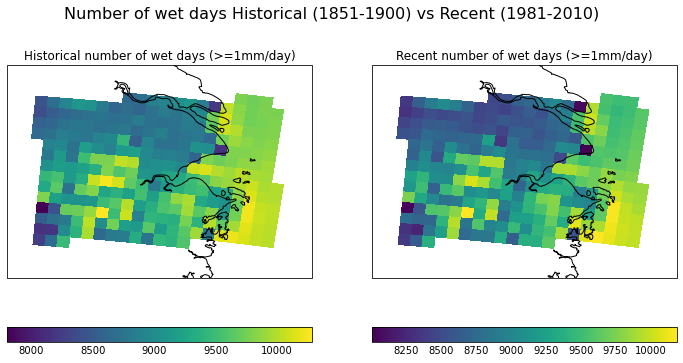

In [15]:
# plot the data as number of wet days
fig = plt.figure(figsize=(12, 6))
fig.suptitle('Number of wet days Historical (1851-1900) vs Recent (1981-2010)', fontsize=16)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
qplt.pcolormesh(past_wetdays)
ax1.coastlines()
ax1 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
qplt.pcolormesh(recent_wetdays)
ax1.coastlines()
plt.show()

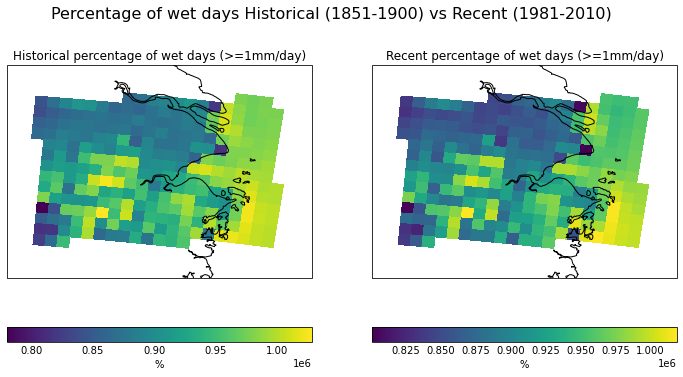

In [16]:
# plot the data as percentage of wet days
fig = plt.figure(figsize=(12, 6))
fig.suptitle('Percentage of wet days Historical (1851-1900) vs Recent (1981-2010)', fontsize=16)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
qplt.pcolormesh(pcent_past_wetdays)
ax1.coastlines()
ax1 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
qplt.pcolormesh(pcent_recent_wetdays)
ax1.coastlines()
plt.show()

## 2. Percentiles<a id='percent'></a>

### 2.1 Calculating 95th percentile of precipitation

In this section we will calculate the extreme precipitation i.e. 95th percentile. We have already extracted our cube *Pflx%* so we can use the *iris.analysis.PERCENTILE* method to calculate the percentile.

In [ ]:
pflx_pc95 = pflx.collapsed('time', iris.analysis.PERCENTILE, percent=95.)
pflx_pc95.rename('R95p of daily rainfall')
pflx_pc95.convert_units('kg m-2 d-1')

In [ ]:
fig = plt.figure(figsize=(12, 6))
fig.suptitle('Extreme rainfall', fontsize=16)
qplt.pcolormesh(pflx_pc95)
plt.gca().coastlines()
plt.show()

</pre><div class="alert alert-block alert-success">
    <b>Task:</b><br><ul>
        <li> Calculate the change in extreme precipitation over south east coast. 
    </ul>
</div>

In [ ]:
# Write your code here ..

In [ ]:
# Write your code here ..

___

## 3. Investigate extremes<a id='extremes'></a>

### 3.1 Calculate the extreme index TX90P

Calculate the frequency of warm days in the present (extreme index TX90P), i.e. the number of days which exceed the 90th percentile temperatures in the baseline. Then calculate the numbers of days as a percentage.

In [ ]:
# first extract the air_temperature at 1.5m cubes from the cubelist
air_temp = cubelist.extract('air_temperature' & iris.AttributeConstraint(Height='1.5 m'))

# constraint for the maximum temperature 
max_temp_cons = iris.Constraint(cube_func=lambda c: (len(c.cell_methods) > 0) and 
                                (c.cell_methods[0].method == 'maximum'))

# define time constraint and extract 1851-1900 period (the baseline)
start_time = 1851
end_time = 1900

# define the time constraint
time_constraint = iris.Constraint(time=lambda cell: start_time <= cell.point.year <= end_time)

# applying the pressure, maximum temperature and time constraints getting a single cube
max_temp = air_temp.extract_strict(max_temp_cons & time_constraint)

# defining Shangai region coords
min_lat=29.0
max_lat=32.0
min_lon=118.0
max_lon=123.0

# extract data for the the Shanghai region using extract_rot_cube() function
max_temp = extract_rot_cube(max_temp, min_lat, min_lon, max_lat, max_lon)



In [ ]:
max_temp_pc90 = max_temp.collapsed('time', iris.analysis.PERCENTILE, percent=90.)
max_temp_pc90.rename('R90p of daily maximum temperature')

In [ ]:
# Now extract present day
# extract a single cube of maximum air_temperature at 1.5m cube from the cubelist
max_temp = cubelist.extract_strict('air_temperature' & iris.AttributeConstraint(Height='1.5 m') &
                           max_temp_cons)
# extract data for the the Shanghai region using extract_rot_cube() function
max_temp = extract_rot_cube(max_temp, min_lat, min_lon, max_lat, max_lon)

start_time = 1981
end_time = 2010

time_constraint = iris.Constraint(time=lambda cell: start_time <= cell.point.year <= end_time)
max_temp = max_temp.extract(time_constraint)


Now we need to calculate the number of warm days, we do so by counting all the data points that are greater than 90th percentile of the baseline period within the last 30 years.

In [ ]:
# make new cube to hold the counts
nwarmdays = max_temp_pc90.copy()

# Use broadcasting to identify all cells where daily temperatures in the future exceed the 95th percentile
temp_gt_pc90 = np.where(max_temp.data >= max_temp_pc90.data, 1, 0)
nwarmdays.data = np.ma.sum(temp_gt_pc90, axis=0)
# the sum above removes the mask - reinstate it with 
nwarmdays.data.mask = max_temp_pc90.data.mask
nwarmdays.units = '1'


In [ ]:
qplt.pcolormesh(nwarmdays)
plt.gca().coastlines() 
plt.show()


Calculate percentage of warmest days by using **iris.analysis.maths**

In [ ]:
ndays = max_temp.shape[0]
# calculating percentage 
nwd_pcent = iris.analysis.maths.divide(iris.analysis.maths.multiply(nwarmdays, 100), ndays)
nwd_pcent.units="%"

Ploting the percentage of warm days

In [ ]:
qplt.pcolormesh(nwd_pcent)
plt.title('Percentage of warm days')
plt.gca().coastlines() 
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
    <b>Task:</b><br><ul>
        <li> Calculate and plot the past (1851-1880) and present (1981-2010) 90th percentile of maximum temperature and the difference between them.
    </ul>
</div>

In [6]:
# first extract the air_temperature at 1.5m cubes from the cubelist
air_temp = cubelist.extract('air_temperature' & iris.AttributeConstraint(Height='1.5 m'))

# constraint for the maximum temperature 
max_temp_cons = iris.Constraint(cube_func=lambda c: (len(c.cell_methods) > 0) and 
                                (c.cell_methods[0].method == 'maximum'))

# define time constraint and extract 1851-1900 period (the baseline)
start_time = 1851
end_time = 1880

# define the time constraint
time_constraint = iris.Constraint(time=lambda cell: start_time <= cell.point.year <= end_time)

# applying the pressure, maximum temperature and time constraints getting a single cube
past_max_temp = air_temp.extract_strict(max_temp_cons & time_constraint)

# defining Shangai region coords
min_lat=29.0
max_lat=32.0
min_lon=118.0
max_lon=123.0

# extract data for the the Shanghai region using extract_rot_cube() function
past_max_temp_shanghai = extract_rot_cube(past_max_temp, min_lat, min_lon, max_lat, max_lon)

In [26]:
# calculate the 90 percentile
past_max_temp_shanghai_pc90 = past_max_temp_shanghai.collapsed('time', iris.analysis.PERCENTILE, percent=90.)
past_max_temp_shanghai_pc90.rename('Historic R90p of daily maximum temperature')

/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/coords.py:1193: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/coords.py:1193: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


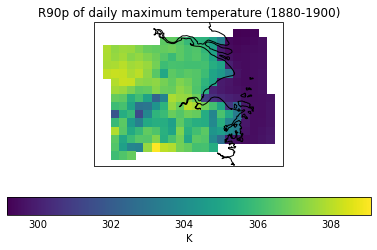

In [35]:
# let's plot the historic data
qplt.pcolormesh(past_max_temp_shanghai_pc90)
plt.title('R90p of daily maximum temperature (1880-1900)')
plt.gca().coastlines() 
plt.tight_layout()
plt.show()

In [9]:
# Now extract present day
# extract a single cube of maximum air_temperature at 1.5m cube from the cubelist
max_temp = cubelist.extract_strict('air_temperature' & iris.AttributeConstraint(Height='1.5 m') &
                           max_temp_cons)
# extract data for the the Shanghai region using extract_rot_cube() function
max_temp_shanghai = extract_rot_cube(max_temp, min_lat, min_lon, max_lat, max_lon)

start_time = 1981
end_time = 2010

time_constraint = iris.Constraint(time=lambda cell: start_time <= cell.point.year <= end_time)
recent_max_temp_shanghai = max_temp_shanghai.extract(time_constraint)

In [30]:
# calculate the 90 percentile
recent_max_temp_shanghai_pc90 = recent_max_temp_shanghai.collapsed('time', iris.analysis.PERCENTILE, percent=90.)
recent_max_temp_shanghai_pc90.rename('Recent R90p of daily maximum temperature')

/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/coords.py:1193: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/coords.py:1193: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


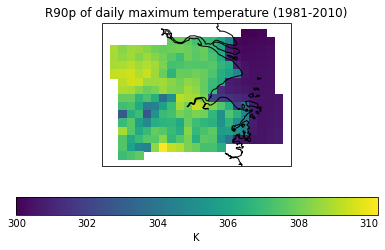

In [36]:
# let's plot the recent data
qplt.pcolormesh(recent_max_temp_shanghai_pc90)
plt.title('R90p of daily maximum temperature (1981-2010)')
plt.gca().coastlines() 
plt.tight_layout()
plt.show()

In [32]:
# now let calculate the difference plot
diff_max_temp_shanghai_pc90 = recent_max_temp_shanghai_pc90 - past_max_temp_shanghai_pc90
diff_max_temp_shanghai_pc90.rename('Difference R90p of daily maximum temperature')

/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/coords.py:1193: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/coords.py:1193: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


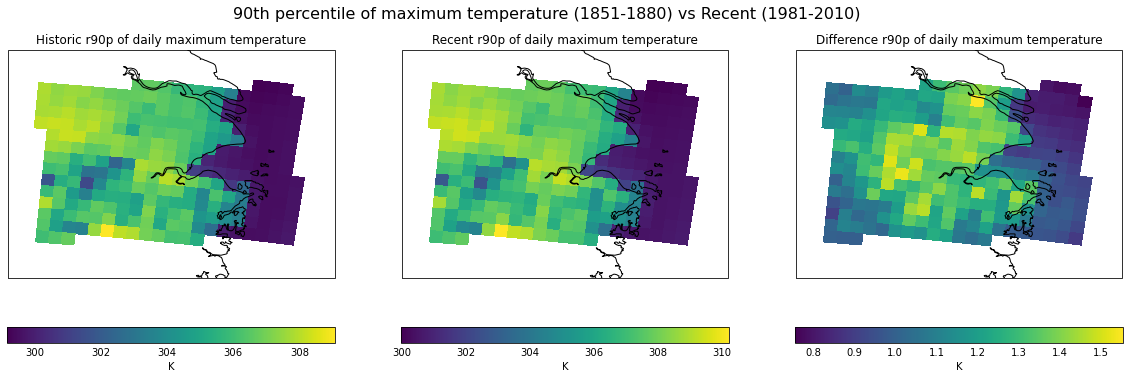

In [34]:
# and finally plot the historic, recent and difference plots next to each other
fig = plt.figure(figsize=(20, 6))
fig.suptitle('90th percentile of maximum temperature (1851-1880) vs Recent (1981-2010)', fontsize=16)
ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
qplt.pcolormesh(past_max_temp_shanghai_pc90)
ax1.coastlines()
ax1 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
qplt.pcolormesh(recent_max_temp_shanghai_pc90)
ax1.coastlines()
ax1 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
qplt.pcolormesh(diff_max_temp_shanghai_pc90)
ax1.coastlines()
plt.show()

___

## 4. Exercises<a id='exercise'></a>

In this exercise we will calculate the percentage of total precipitation from 1981-2010 which falls on very wet days (where a very wet day is one on which daily rainfall exceeds the 95th percentile of the baseline) over Shanghai region.

Further we also calculate the percentage of very wet days in the past (1851-1880) and see the difference by plotting the difference of heavy rainfall in the past and present.

### Exercise 1: calculate the percentage of total precipitation from 1981-2010 on very wet days (=> 95th Percentile)

In [3]:
# write your code here ...

### Exercise 2: calculate the percentage of total precipitation from 1951-1880 on very wet days (=> 95th Percentile)

In [4]:
# write your code here ...

### Exercise 3: Calculate the difference 

In [5]:
# write your code here ...

### Exercise 4: Plot the percentages and difference 

In [ ]:
# write your code here ...

___

<div class="alert alert-block alert-success">
<b>Summary</b><br> 
    In this session we learned how:<br>
    <ul>
        <li>to calculate extreme values and percentages
        <li>to calcuate basic extreme value indices  
    </ul>

</div>
